In [1]:
from IPython.display import clear_output
from collections import OrderedDict
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# I) Loading dataset / Preprocessing

In [2]:
is_gpu_available = torch.cuda.is_available()

In [3]:
def load_mnist():
    transform = transforms.Compose([transforms.Resize((64,64)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
            
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    # Clear downloading message.
    clear_output()
    
    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (55000, 5000))
    
    print("Image Shape: {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    print("Training Set:   {} samples".format(len(train_dataset)))
    print("Validation Set:   {} samples".format(len(val_dataset)))
    print("Test Set:       {} samples".format(len(test_dataset)))
    
    # Create iterator.
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    
    # Delete the data/ folder.
    shutil.rmtree('./data')
    
    return (train_loader, val_loader, test_loader)

In [4]:
train_loader, val_loader, test_loader = load_mnist()

Image Shape: (1, 64, 64)

Training Set:   55000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


# II) Visualization

In [5]:
def plot_example(X, y, y_pred=None):
    """
        Plots 9 examples and their associate labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    """
    # Create figure with 3 x 3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
     
    X, y = X[:9, 0, ...], y[:9] 
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(X[i])

        # Show true and predicted classes.
        if y_pred is None:
            xlabel = "True: {0}".format(y[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [6]:
def plot_example_errors(X, y, y_pred):
    """
        Plots 9 example errors and their associate true/predicted labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    
    """
    incorrect = (y != y_pred)
 
    X = X[incorrect]
    y = y[incorrect]
    y_pred = y_pred[incorrect]

    # Plot the first 9 images.
    plot_example(X, y, y_pred)

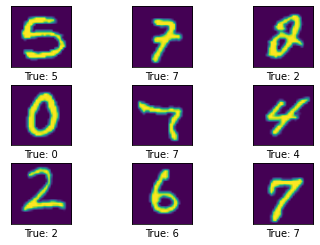

In [7]:
images, labels = iter(train_loader).next()
plot_example(images.numpy(), labels.numpy())

# III) Architecture build¶

## a) Generator

In [8]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.network = nn.Sequential(OrderedDict([
            ('tp_conv1', nn.ConvTranspose2d(100, 1024, kernel_size=4, stride=1, padding=0)),
            ('bn1', nn.BatchNorm2d(1024)),
            ('act1', nn.ReLU()),
            
            ('tp_conv2', nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)),
            ('bn2', nn.BatchNorm2d(512)),
            ('act2', nn.ReLU()),
            
            ('tp_conv3', nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)),
            ('bn3', nn.BatchNorm2d(256)),
            ('act3', nn.ReLU()),
            
            ('tp_conv4', nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)),
            ('bn4', nn.BatchNorm2d(128)),
            ('act4', nn.ReLU()),
            
            ('tp_conv5', nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1)),
            ('act5', nn.Tanh())
        ]))

    def init_weights(self, mean, std):
        for m in self._modules['network']:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()
    
    def forward(self, x):
        out = self.network(x)
        return out

In [9]:
G = Generator()
G.init_weights(mean=0.0, std=0.02)
G

Generator(
  (network): Sequential(
    (tp_conv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU()
    (tp_conv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU()
    (tp_conv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU()
    (tp_conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act4): ReLU()
    (tp_conv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (act5): Tanh()
  )
)

## b) Discriminator

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.network = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1)),
            ('act1', nn.LeakyReLU(0.2)),
            
            ('conv2', nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            ('bn2', nn.BatchNorm2d(256)),
            ('act2', nn.LeakyReLU(0.2)),
            
            ('conv3', nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)),
            ('bn3', nn.BatchNorm2d(512)),
            ('act3', nn.LeakyReLU(0.2)),
            
            ('conv4', nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)),
            ('bn4', nn.BatchNorm2d(1024)),
            ('act4', nn.LeakyReLU(0.2)),
            
            ('conv5', nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0)),
            ('act5', nn.Sigmoid())
        ]))
    
    def init_weights(self, mean, std):
        for m in self._modules['network']:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()
    
    def forward(self, x):
        out = self.network(x)
        return out

In [11]:
D = Discriminator()
D.init_weights(mean=0.0, std=0.02)
D

Discriminator(
  (network): Sequential(
    (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (act1): LeakyReLU(negative_slope=0.2)
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): LeakyReLU(negative_slope=0.2)
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): LeakyReLU(negative_slope=0.2)
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act4): LeakyReLU(negative_slope=0.2)
    (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (act5): Sigmoid()
  )
)

## c) Optimizers & Loss

In [12]:
# Optimizers.
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss.
def real_loss(D_out, smooth=False):
    '''
        Calculates how close discriminator outputs are to being real.
        
        Params:
        -D_out: discriminator logits.
    '''
    batch_size = D_out.size(0)
    
    # label smoothing.
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1.

    if is_gpu_available:
        labels = labels.cuda()

    # numerically stable loss.
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''
        Calculates how close discriminator outputs are to being fake.
        
        Params:
        -D_out: discriminator logits.
    '''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0.
    
    if is_gpu_available:
        labels = labels.cuda()
    
    criterion = nn.BCELoss()
    
    # Calculate loss.
    loss = criterion(D_out.squeeze(), labels)
    return loss

# IV) Training phase


In [13]:
def train(D, G):
    EPOCHS = 10
    
    if is_gpu_available:
        D.cuda()
        G.cuda()
        
    losses = []
        
    for epoch in range(EPOCHS):
            
        for i, (real_images, _) in enumerate(train_loader):
            
            batch_size = real_images.size(0)
            
            # ---------TRAIN THE DISCRIMINATOR ----------------
            D_optimizer.zero_grad()
            
            # 1. Train with real images.
            if is_gpu_available:
                real_images = real_images.cuda()
            
            # Compute the discriminator losses on real images
            # smooth the real labels.
            D_real = D(real_images)
            D_real_loss = real_loss(D_real, smooth=True)
            
            # 2. Train with fake images.
            # Generate fake images.
            z = np.random.uniform(-1, 1, size=(batch_size, 100, 1, 1))
            z = torch.from_numpy(z).float()
            
            if is_gpu_available:
                z = z.cuda()
                
            fake_images = G(z)
            
            # 3. Compute the discriminator losses on fake images.
            D_fake = D(fake_images)
            D_fake_loss = fake_loss(D_fake)
            
            # 4. Add up real and fake loss.
            D_loss = D_real_loss + D_fake_loss
            
            # 5. Perform backprop and optimization step.
            D_loss.backward()
            D_optimizer.step()
            
            # ---------TRAIN THE GENERATOR ----------------
            
            G_optimizer.zero_grad()
            
            # 1. Generate fake images.
            z = np.random.uniform(-1, 1, size=(batch_size, 100, 1, 1))
            z = torch.from_numpy(z).float()
            
            if is_gpu_available:
                z = z.cuda()
            
            fake_images = G(z)
            
            # 2. Compute the discriminator loss on fake images
            # using flipped labels.
            D_fake = D(fake_images)
            G_loss = real_loss(D_fake) # use real loss to flip labels.
            
            # 3. Perform backprop and optimization step.        
            G_loss.backward()
            G_optimizer.step()
        
        # Append discriminator loss and generator loss.
        losses.append((d_loss.item(), g_loss.item()))
        # Print discriminator and generator loss.
        info = "[Epoch {}/{}]: D_loss = {:0.6f} | G_loss = {:0.6f}"
        print(info.format(epoch+1, EPOCHS, D_loss.item(), G_loss.item()))
    
    torch.save(model.state_dict(), 'train_model') 
    
    return losses

In [14]:
losses = train(D, G)

KeyboardInterrupt: 

# V) Evaluating the model